# AMOC calculations

AMOC calculation development and testing notebook

***

In [1]:
import numpy as np
import xarray as xr
import geojson
from matplotlib import pyplot as plt
from tqdm import tqdm
from mpas_tools.mesh.creation.signed_distance import mask_from_geojson
from itertools import pairwise

plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

### Code development starts here ...

In [2]:
def get_region_edges(regionCellMask, cellsOnEdge):
    """
    Get open water edges of an MPAS-Ocean masked region.
    """
    
    # Exclude land edges
    dropEdges = np.any(cellsOnEdge == -1, axis=1)
    
    # Exclude water edges that don't straddle the regionCellMask boundary (e.g. 0 neigboring 1)
    regionCellMaskNeighbors = [regionCellMask[cellsOnEdge[~dropEdges, col]] for col in (0, 1)]
    dropEdges[~dropEdges] = np.equal(*regionCellMaskNeighbors)
    
    # Find open boundary edges and signs (positive INTO region)
    openBoundaryEdges, = np.where(~dropEdges)
    openBoundarySigns = np.sign((regionCellMask[cellsOnEdge[~dropEdges, 1]] - 0.5))
    
    return openBoundaryEdges, openBoundarySigns

In [5]:
# Sigma bins
sigmaBins = np.arange(22, 29.01, 0.1)

# Load NA mask
maskfile = '/pscratch/sd/b/bmoorema/maskfiles/EC30to60E2r2_AtlanticMask20250626.nc'
ds = xr.open_dataset(maskfile)
mask_NA = ds.regionCellMasks[:, 0].values
cells, = np.where(mask_NA.astype(bool))

# Load coords
meshfile = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
ds = xr.open_dataset(meshfile)
lonCell = np.rad2deg(ds['lonCell'].values[cells])
latCell = np.rad2deg(ds['latCell'].values[cells])
latEdge = np.rad2deg(ds['latEdge'].values)
lonCell = np.where(lonCell > 180, lonCell - 360, lonCell)
area = ds.areaCell.values[cells]
depths = ds.refBottomDepth.values
dvEdge = ds.dvEdge.values
cellsOnEdge = ds.cellsOnEdge.values - 1

# Get southern transect
edges, signs = get_region_edges(mask_NA, cellsOnEdge)
idx = latEdge[edges] < -30
edges, signs = edges[idx], signs[idx]
latEdge, dvEdge, cellsOnEdge = latEdge[edges], dvEdge[edges], cellsOnEdge[edges]

In [6]:
AMOC = []
for month in tqdm(range(1, 13)):
    
    # Load results
    resultsfile = f'/pscratch/sd/b/bmoorema/run_001_062/20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0001-{month:02d}-01.nc'
    ds = xr.open_dataset(resultsfile)
    
    # Sigma
    sigma = ds.timeMonthly_avg_potentialDensity[0, ...].values - 1000
    sigmaEdge = (sigma[cellsOnEdge[:, 0]] + sigma[cellsOnEdge[:, 1]]) / 2
    sigma = sigma[cells]
    
    # Layer Thickness
    h = ds.timeMonthly_avg_layerThickness[0, ...].values
    h = (h[cellsOnEdge[:, 0]] + h[cellsOnEdge[:, 1]]) / 2
    
    # Vertical velocity
    w = ds.timeMonthly_avg_vertVelocityTop[0, :, :-1].values[cells]
    w = w * area[:, None]
    
    # Transect velocity
    v = ds.timeMonthly_avg_normalVelocity[0, ...].values[edges]
    v = v * h * (dvEdge * signs)[:, None]
    
    # Edge
    binned = np.histogram(sigmaEdge.ravel(), bins=sigmaBins, weights=v.ravel())[0]
    amocEdge = -np.cumsum(binned[::-1])[::-1]
    
    # Interior
    amocInterior = []
    sigmaBins = np.arange(20, 29.1, 0.1)
    latBinEdges = np.arange(-34, 83)
    for lat1, lat2 in pairwise(latBinEdges):
        mask_lat = np.logical_and(latCell >= lat1, latCell < lat2)
        binned = np.histogram(sigma[mask_lat, :].ravel(), bins=sigmaBins, weights=w[mask_lat, :].ravel())[0]
        amocInterior.append(binned)
    amocInterior = np.cumsum(amocInterior, axis=0)
    
    # Total
    AMOC.append((amocEdge[None, :] + amocInterior).T * 1e-6)

  0%|          | 0/12 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (1,70) (116,91) 

(28.5, 26.0)

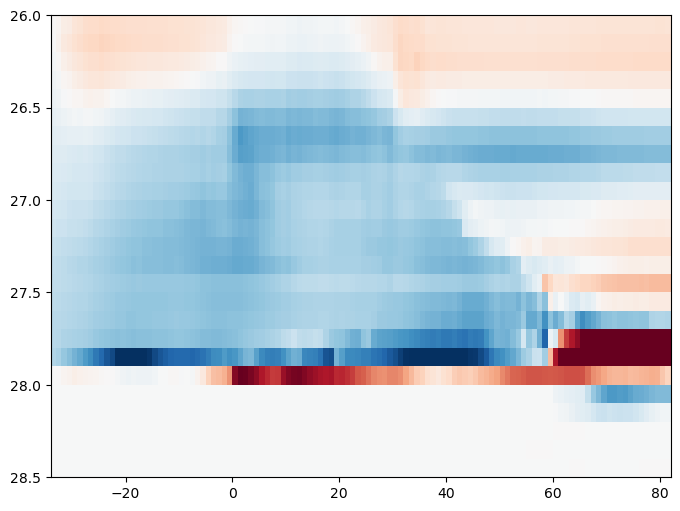

In [168]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.pcolormesh(latBinEdges, sigmaBins, np.mean(AMOC, axis=0), vmin=-50, vmax=50, cmap='RdBu')
ax.set_ylim([28.5, 26])

***

### Workflow on remapped fields

In [2]:
# Slice to subdomain
bbox = [-100, 30, -30, 85]
args={'Time': 0, 'lon': slice(*bbox[:2]), 'lat': slice(*bbox[2:])}
ds = ds.sel(**args)

# Get variables
lons, lats = ds_v.lon.values, ds_v.lat.values
v = ds_v.timeMonthly_avg_velocityMeridional.values
w = ds_w.timeMonthly_avg_vertVelocityTop.values
sigma = ds_pd.timeMonthly_avg_potentialDensity.values - 1000

# Load mask
with open('/pscratch/sd/a/abhi305/mask_files/atlantic_mask.geojson') as f:
    fc = geojson.load(f)
na_mask = mask_from_geojson(fc, lons, lats)

# Mask Atlantic and bad regions
v[:, ~na_mask] = np.nan
w[:, ~na_mask] = np.nan
sigma[:, ~na_mask] = np.nan

# Integration quantities
dx, dy = 0.1 * 111e3 * np.cos(np.deg2rad(lats)), 0.1 * 111e3
areaCell = dx * dy
layer_thickness = np.diff(depth, prepend=0)

Mask from geojson
-----------------


***

### AMOC method 1: Transport from divergence

In [3]:
# Cell divergence from diff(w) (zonal integral)
divergence = np.nansum(np.diff(w, axis=0) * areaCell[None, :, None], axis=2)

# Transport at southern edge (zonal integral)
transport_south = np.nansum(v[:, 0, :], axis=1) * dx[0] * layer_thickness

# Interior transport
transport = (transport_south[:, None] + np.nancumsum(divergence, axis=1)) * 1e-6

# Stream function
psi = -np.nancumsum(transport[::-1, :], axis=0)[::-1, :]

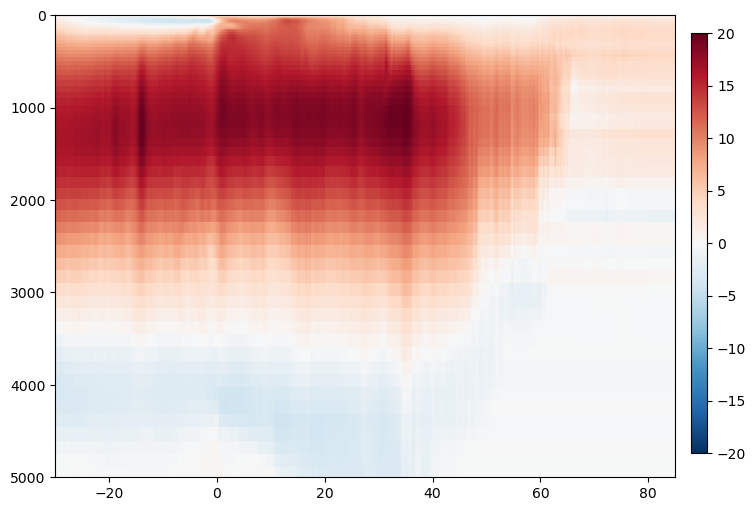

In [4]:
# Plot stream function
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(lats, depth, psi, cmap='RdBu_r', vmin=-20, vmax=20)
ax.set_ylim(5000, 0)
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cax)

***

### AMOC method 2: Stream function from vertical transport (MPAS Analysis version)

In [5]:
# Cell vertical transport from w (zonal integral)
transport_vertical = np.nansum(w[:-1, ...] * areaCell[None, :, None], axis=2)

# Transport at southern edge (zonal integral)
transport_south = np.nansum(v[:, 0, :], axis=1) * dx[0] * layer_thickness

# Stream function at southern edge
psi = -np.nancumsum(transport_south[::-1])[::-1]

# Interior stream function
psi = (psi[:, None] + np.nancumsum(transport_vertical, axis=1)) * 1e-6

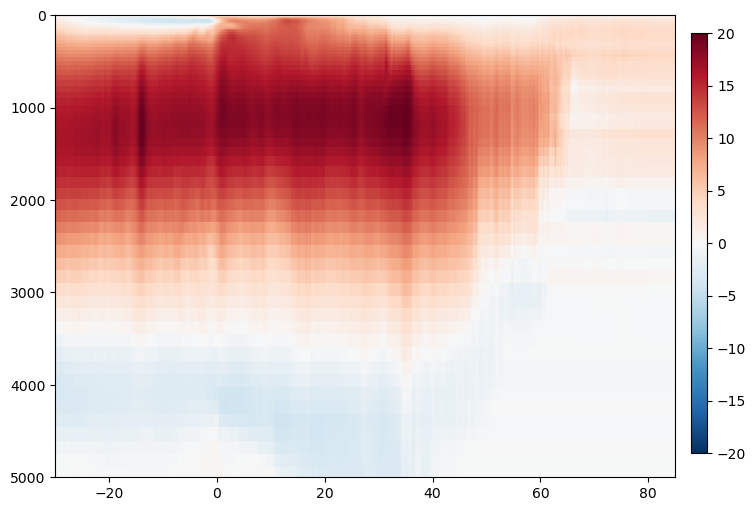

In [6]:
# Plot stream function
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(lats, depth, psi, cmap='RdBu_r', vmin=-20, vmax=20)
ax.set_ylim(5000, 0)
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cax)